### CNN - First Try

This is the first CNN model we try. You can see other CNN models in other code files

In [1]:
# Using GPU to train CNN
!nvidia-smi

Tue Jun 02 22:19:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.87       Driver Version: 445.87       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0  On |                  N/A |
| 52%   57C    P0    65W / 260W |    674MiB / 11264MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.models import Model, Sequential, load_model, Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.optimizers import Adam
from keras.models import Model
import keras
from keras import optimizers

Using TensorFlow backend.


In [3]:
# Check whether using GPU
tf.test.gpu_device_name()

'/device:GPU:0'

### Read and preprocessing labels & Images

In [4]:
Train=pd.read_csv('plant-pathology-2020-fgvc7/train.csv')
Test=pd.read_csv('plant-pathology-2020-fgvc7/test.csv')

In [5]:
# Resizing images
img_size=100
Train_image=[]
for name in Train['image_id']:
    path='plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    Train_image.append(image)

Test_image=[]
for name in Test['image_id']:
    path='plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    Test_image.append(image)

In [6]:
# Vectorizing the channels - image to array
X_train = np.ndarray(shape=(len(Train_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in Train_image:
    X_train[i]=img_to_array(image)
    X_train[i]=Train_image[i]
    i=i+1
X_train=X_train/255
print('Train Shape: {}'.format(X_train.shape))

X_test = np.ndarray(shape=(len(Test_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in Test_image:
    X_test[i]=img_to_array(image)
    X_test[i]=Test_image[i]
    i=i+1
    
X_test=X_test/255
print('Test Shape: {}'.format(X_test.shape))

Train Shape: (1821, 100, 100, 3)
Test Shape: (1821, 100, 100, 3)


In [7]:
# Deal with labels
Y = Train.copy()
del Y['image_id']
Y.head()
Y_train = np.array(Y.values)
Y_train.shape

(1821, 4)

In [8]:
# We split the training set into training and testing set
train_x,test_x,train_y,test_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [9]:
# Dealing with imbalanced dataset - oversampling
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 0) 
 
train_x,train_y = sm.fit_resample(train_x.reshape((-1, img_size * img_size * 3)), train_y)
train_x = train_x.reshape((-1, img_size, img_size, 3))
train_x.shape, train_y.sum(axis=0)

((1960, 100, 100, 3), array([490, 490, 490, 490]))

In [11]:
# Set early stopping and dynamic learning rates
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=0.5,
                            patience=6,
                            min_lr=0.00001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=20)

In [12]:
# CNN model
reg = .0005

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(5,5),activation='relu', input_shape=(img_size, img_size, 3), 
                                 kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Conv2D(128, kernel_size=(5,5),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(4,activation='softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 128)       102528    
_________________________________________________________________
batch_normalization_2 (Batch (None, 92, 92, 128)       384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 270848)           

In [13]:
# Image augmentation
data_aug = ImageDataGenerator(rotation_range=45,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              shear_range=0.2,
                              rescale=1/255,
                              brightness_range=[0.5,1.5],
                              horizontal_flip=True,
                              vertical_flip=True)

In [14]:
# Start to train model
model.fit_generator(data_aug.flow(train_x,train_y,batch_size=32),
                    steps_per_epoch=train_x.shape[0]//32,
                    epochs=200,
                    verbose=1,
                    validation_data=(test_x,test_y),
                    callbacks=[ES_monitor,LR_reduce],
                    use_multiprocessing=False,
                    workers=1)

Epoch 1/200
61/61 [==============================] - 5s 87ms/step - loss: 1.7151 - accuracy: 0.3107 - val_loss: 1.7113 - val_accuracy: 0.0438
Epoch 2/200
61/61 [==============================] - 4s 66ms/step - loss: 1.5010 - accuracy: 0.3610 - val_loss: 1.9827 - val_accuracy: 0.0521
Epoch 3/200
61/61 [==============================] - 4s 65ms/step - loss: 1.4792 - accuracy: 0.3543 - val_loss: 2.0546 - val_accuracy: 0.0438
Epoch 4/200
61/61 [==============================] - 4s 65ms/step - loss: 1.4301 - accuracy: 0.3729 - val_loss: 2.8543 - val_accuracy: 0.0438
Epoch 5/200
61/61 [==============================] - 4s 65ms/step - loss: 1.4107 - accuracy: 0.3610 - val_loss: 2.0671 - val_accuracy: 0.1151
Epoch 6/200
61/61 [==============================] - 4s 65ms/step - loss: 1.3339 - accuracy: 0.4196 - val_loss: 1.5661 - val_accuracy: 0.1753
Epoch 7/200
61/61 [==============================] - 4s 65ms/step - loss: 1.3516 - accuracy: 0.4072 - val_loss: 1.6645 - val_accuracy: 0.1863
Epoch 

61/61 [==============================] - 4s 64ms/step - loss: 0.6596 - accuracy: 0.7676 - val_loss: 0.6158 - val_accuracy: 0.7589
Epoch 112/200
61/61 [==============================] - 4s 62ms/step - loss: 0.6925 - accuracy: 0.7342 - val_loss: 0.6220 - val_accuracy: 0.7562
Epoch 113/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6889 - accuracy: 0.7341 - val_loss: 0.6198 - val_accuracy: 0.7671
Epoch 114/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6611 - accuracy: 0.7573 - val_loss: 0.6054 - val_accuracy: 0.7644
Epoch 115/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6933 - accuracy: 0.7360 - val_loss: 0.6165 - val_accuracy: 0.7616
Epoch 116/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6829 - accuracy: 0.7516 - val_loss: 0.6213 - val_accuracy: 0.7589
Epoch 117/200
61/61 [==============================] - 4s 63ms/step - loss: 0.6544 - accuracy: 0.7631 - val_loss: 0.6193 - val_accuracy: 0.7616
Epoch 

Epoch 168/200
61/61 [==============================] - 4s 63ms/step - loss: 0.6601 - accuracy: 0.7505 - val_loss: 0.5671 - val_accuracy: 0.7863
Epoch 169/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6353 - accuracy: 0.7624 - val_loss: 0.5596 - val_accuracy: 0.7863
Epoch 170/200
61/61 [==============================] - 4s 63ms/step - loss: 0.6205 - accuracy: 0.7721 - val_loss: 0.5654 - val_accuracy: 0.7863
Epoch 171/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6202 - accuracy: 0.7739 - val_loss: 0.5722 - val_accuracy: 0.7753
Epoch 172/200
61/61 [==============================] - 4s 64ms/step - loss: 0.6248 - accuracy: 0.7669 - val_loss: 0.5466 - val_accuracy: 0.7945
Epoch 173/200
61/61 [==============================] - 4s 63ms/step - loss: 0.6201 - accuracy: 0.7811 - val_loss: 0.5608 - val_accuracy: 0.7890
Epoch 174/200
61/61 [==============================] - 4s 62ms/step - loss: 0.6299 - accuracy: 0.7673 - val_loss: 0.5434 - val_accuracy:

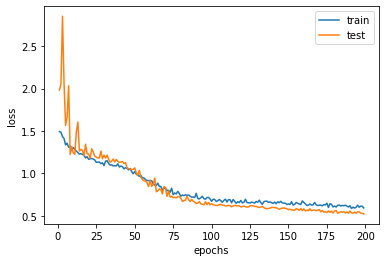

In [15]:
# Plot loss
history = model.history.history
offset = 1
epochs = range(offset, len(history['loss']))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, history['loss'][offset:], label='train')
plt.plot(epochs, history['val_loss'][offset:], label='test')
plt.legend()

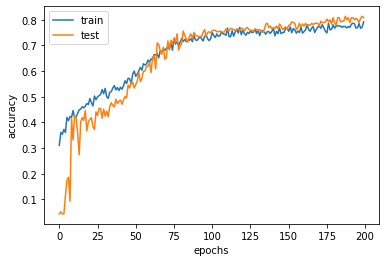

In [16]:
# plot accuracy
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history[f'accuracy'], label='train')
plt.plot(history[f'val_accuracy'], label='test')
plt.legend()

In [17]:
Y1 = Test.copy()
del Y1['image_id']
Y1.head()
Y_test = np.array(Y1.values)
Y_test.shape

(1821, 0)

In [18]:
# predict on the testing set
predict_prob = model.predict(X_test)
df_predict_prob = pd.DataFrame(predict_prob, columns=['healthy','multiple_diseases','rust','scab'])

In [19]:
# output csv files for submission
frame = [Test['image_id'], df_predict_prob]
df_submission = pd.concat(frame, axis=1)
df_submission.to_csv(r'submisson.csv', index=False)